In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

### Retrieve chart from TV

                    symbol      open      high       low     close       volume
datetime                                                                       
2020-02-06 15:30:00  :AAPL   80.6425   81.3050   80.0662   81.3025  105425540.0
2020-02-07 15:30:00  :AAPL   80.5925   80.8500   79.5000   80.0075  117684048.0
2020-02-10 15:30:00  :AAPL   78.5450   80.3875   78.4625   80.3875  109348860.0
2020-02-11 15:30:00  :AAPL   80.9000   80.9750   79.6775   79.9025   94323120.0
2020-02-12 15:30:00  :AAPL   80.3675   81.8050   80.3675   81.8000  113730292.0
...                    ...       ...       ...       ...       ...          ...
2024-01-22 15:30:00  :AAPL  192.3000  195.3300  192.2600  193.8900   60133852.0
2024-01-23 15:30:00  :AAPL  195.0200  195.7500  193.8299  195.1800   42355590.0
2024-01-24 15:30:00  :AAPL  195.4200  196.3800  194.3400  194.5000   53631316.0
2024-01-25 15:30:00  :AAPL  195.2200  196.2675  193.1125  194.1700   54822126.0
2024-01-26 15:30:00  :AAPL  194.2700  19

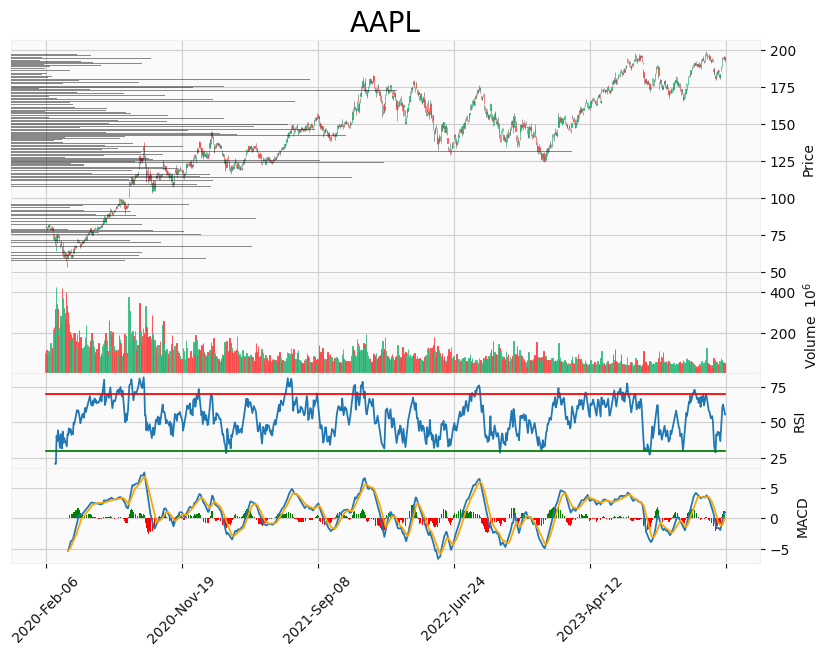

In [8]:
from stockMarket.core import Technicals

contract = Technicals(ticker="AAPL")
contract.init_pricing_data()
print(contract.pricing_data)
rsi = contract.rsi()
macd = contract.macd()
contract.plot(rsi=rsi, macd=macd)

                         open      high       low     close     volume
datetime                                                              
2023-09-05 15:30:00  5.237930  5.246919  5.234365  5.245444  17.628377
2023-09-06 15:30:00  5.238567  5.240953  5.201090  5.208994  18.219248
2023-09-07 15:30:00  5.165814  5.182963  5.156408  5.179309  18.538364
2023-09-08 15:30:00  5.183748  5.194284  5.180603  5.182794  17.999118
2023-09-11 15:30:00  5.193346  5.194622  5.178069  5.189395  17.892252
...                       ...       ...       ...       ...        ...
2024-01-22 15:30:00  5.259057  5.274690  5.258849  5.267291  17.912084
2024-01-23 15:30:00  5.273102  5.276838  5.266981  5.273922  17.561611
2024-01-24 15:30:00  5.275151  5.280052  5.269609  5.270432  17.797644
2024-01-25 15:30:00  5.274127  5.279479  5.263273  5.268734  17.819604
2024-01-26 15:30:00  5.269249  5.271768  5.257183  5.259680  17.613110

[100 rows x 5 columns]
                         open      high  ...  support

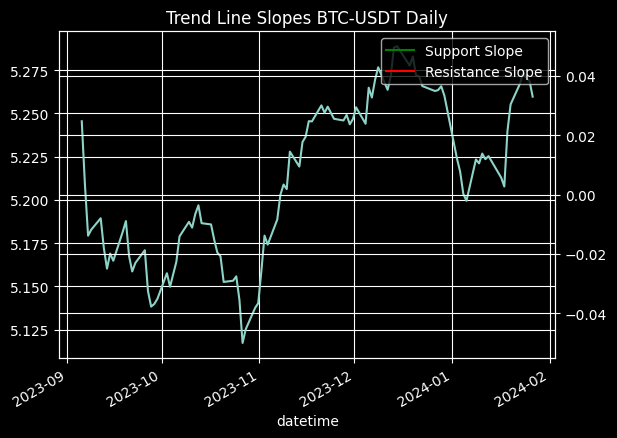

In [79]:
from stockMarket.core import Technicals
from scipy.signal import argrelextrema
import numpy as np
import matplotlib.pyplot as plt

contract = Technicals(ticker="AAPL")
contract.init_pricing_data(interval="monthly", n_bars=1000)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def check_trend_line(support: bool, pivot: int, slope: float, y: np.array):
    # compute sum of differences between line and prices, 
    # return negative val if invalid 
    
    # Find the intercept of the line going through pivot point with given slope
    intercept = -slope * pivot + y[pivot]
    line_vals = slope * np.arange(len(y)) + intercept
     
    diffs = line_vals - y
    
    # Check to see if the line is valid, return -1 if it is not valid.
    if support and diffs.max() > 1e-5:
        return -1.0
    elif not support and diffs.min() < -1e-5:
        return -1.0

    # Squared sum of diffs between data and line 
    err = (diffs ** 2.0).sum()
    return err;


def optimize_slope(support: bool, pivot:int , init_slope: float, y: np.array):
    
    # Amount to change slope by. Multiplyed by opt_step
    slope_unit = (y.max() - y.min()) / len(y) 
    
    # Optmization variables
    opt_step = 1.0
    min_step = 0.0001
    curr_step = opt_step # current step
    
    # Initiate at the slope of the line of best fit
    best_slope = init_slope
    best_err = check_trend_line(support, pivot, init_slope, y)
    assert(best_err >= 0.0) # Shouldn't ever fail with initial slope

    get_derivative = True
    derivative = None
    while curr_step > min_step:

        if get_derivative:
            # Numerical differentiation, increase slope by very small amount
            # to see if error increases/decreases. 
            # Gives us the direction to change slope.
            slope_change = best_slope + slope_unit * min_step
            test_err = check_trend_line(support, pivot, slope_change, y)
            derivative = test_err - best_err;
            
            # If increasing by a small amount fails, 
            # try decreasing by a small amount
            if test_err < 0.0:
                slope_change = best_slope - slope_unit * min_step
                test_err = check_trend_line(support, pivot, slope_change, y)
                derivative = best_err - test_err

            if test_err < 0.0: # Derivative failed, give up
                raise Exception("Derivative failed. Check your data. ")

            get_derivative = False

        if derivative > 0.0: # Increasing slope increased error
            test_slope = best_slope - slope_unit * curr_step
        else: # Increasing slope decreased error
            test_slope = best_slope + slope_unit * curr_step
        

        test_err = check_trend_line(support, pivot, test_slope, y)
        if test_err < 0 or test_err >= best_err: 
            # slope failed/didn't reduce error
            curr_step *= 0.5 # Reduce step size
        else: # test slope reduced error
            best_err = test_err 
            best_slope = test_slope
            get_derivative = True # Recompute derivative
    
    # Optimize done, return best slope and intercept
    return (best_slope, -best_slope * pivot + y[pivot])


def fit_trendlines_single(data: np.array):
    # find line of best fit (least squared) 
    # coefs[0] = slope,  coefs[1] = intercept 
    x = np.arange(len(data))
    coefs = np.polyfit(x, data, 1)

    # Get points of line.
    line_points = coefs[0] * x + coefs[1]

    # Find upper and lower pivot points
    upper_pivot = (data - line_points).argmax() 
    lower_pivot = (data - line_points).argmin() 
   
    # Optimize the slope for both trend lines
    support_coefs = optimize_slope(True, lower_pivot, coefs[0], data)
    resist_coefs = optimize_slope(False, upper_pivot, coefs[0], data)

    return (support_coefs, resist_coefs) 



def fit_trendlines_high_low(high: np.array, low: np.array, close: np.array):
    x = np.arange(len(close))
    coefs = np.polyfit(x, close, 1)
    # coefs[0] = slope,  coefs[1] = intercept
    line_points = coefs[0] * x + coefs[1]
    upper_pivot = (high - line_points).argmax() 
    lower_pivot = (low - line_points).argmin() 
    
    support_coefs = optimize_slope(True, lower_pivot, coefs[0], low)
    resist_coefs = optimize_slope(False, upper_pivot, coefs[0], high)

    return (support_coefs, resist_coefs)


data = contract.pricing_data.copy()
data = data.drop(columns=["symbol"])
data = np.log(data)
print(data)

lookback = 10**6

support_slope = [np.nan] * len(data)
resist_slope = [np.nan] * len(data)
for i in range(lookback - 1, len(data)):
    candles = data.iloc[i - lookback + 1: i + 1]
    support_coefs, resist_coefs =  fit_trendlines_high_low(candles['high'], 
                                                           candles['low'], 
                                                           candles['close'])
    support_slope[i] = support_coefs[0]
    resist_slope[i] = resist_coefs[0]

data['support_slope'] = support_slope
data['resist_slope'] = resist_slope

print(data)

plt.style.use('dark_background')
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
data['close'].plot(ax=ax1)
data['support_slope'].plot(ax=ax2, label='Support Slope', color='green')
data['resist_slope'].plot(ax=ax2, label='Resistance Slope', color='red')
plt.title("Trend Line Slopes BTC-USDT Daily")
plt.legend()
plt.show()
